$\newcommand{\cm}{\mbox{cm}}
\newcommand{\mm}{\mbox{mm}}
\newcommand{\NA}{\mbox{NA}}$
# Propagación
[1] 2017 - Review of digital holography reconstruction methods

Rayleigh-Sommerfeld (convolución):
$$h^{RS}_z = \frac{z}{i\lambda}\frac{\exp(ikr)}{r^2},$$
$$r=\sqrt{x^2+y^2+z^2}$$
En frecuencia no existe una expresión analítica.

La aproximación de Fresnel se realiza cuando $z^3 \gg \frac{\pi l^4}{64\lambda}$, siendo $l$ la dimensión característica del objeto.

Fresnel:
$$h^{F}_z = \frac{\exp(ikz)}{i\lambda z}\exp\left(\frac{i\pi(x^2+y^2)}{\lambda z}\right)$$
$$H^{F}_z = \exp(ikz)\exp[-i\pi \lambda z(v_x^2+v_y^2)]$$

Fresnel Diffraction integral:
$$U_z(x,y) = \frac{\exp(ikz)}{i\lambda z}\exp\left(\frac{i\pi}{\lambda z}(x^2+y^2)\right) \mathfrak{F}\left[U_o(x,y)\exp\left(\frac{i\pi}{\lambda z}(x^2+y^2)\right)\right]$$
$$\Delta\xi = \Delta\eta = \frac{\lambda z}{N\Delta_p},$$
en el plano de reconstrucción. Al pasar a numérico, hay que multiplicar por $\Delta_p^2 $

Cuando $z^3 \gg \frac{k}{2}(\xi^2+\eta^2)$ vale Fraunhofer (en realidad hay que considerar el tamaño del objeto y no de la imagen que se quiere obtener):
$$U_z(x,y) = \frac{\exp(ikz)}{i\lambda z}\exp\left(\frac{i\pi}{\lambda z}(x^2+y^2)\right) \mathfrak{F}[U_o(x,y)]$$

Angular Spectrum Method ($z\gg \lambda$):
$$H^{AS}_z = \exp \left(ikz\sqrt{1-(\lambda v_x)^2-(\lambda v_y)^2}\right)$$,
si: $\sqrt{v_x^2+v_y^2}<1/\lambda$, si no, $H^{AS}_z = 0$

Cuando se pasa a numérico: $\Delta v_x = 1/(M\Delta x)$. O, en particular, $\Delta_p$ cuando $\Delta x = \Delta y$

## Limitaciones por implementación numérica

Rayleigh-Sommerfeld:
$$z_{\min}^{RS} = \sqrt{M^2 + N^2}\Delta_p \sqrt{\left(\frac{\Delta_p}{\lambda}\right)^2-\frac{1}{2}}$$
Fresnel (convolución):
$$z_{\min}^{F} = \sqrt{M^2 + N^2}\Delta_p \frac{\Delta_p}{\lambda}$$
Cuando se trabaja en espectro (Fresnel o ASM):
$$z_{\max}^{ASM} = \min(M,N) \frac{\Delta_p^2}{\lambda}$$

In [1]:
import math
l = 125e-6  # size of object
wavelength = 355e-9
zero_padding = True
M0 = 13264
N0 = 9176
delta_p = 2.2e-6
downsampling = 1
crop_factor = 1
max_z = 96e-2

M0 = 2*M0 if zero_padding else M0
N0 = 2*N0 if zero_padding else N0

Mc = M0 * crop_factor
Nc = N0 * crop_factor
M = Mc / downsampling
N = Nc / downsampling
delta_p = delta_p *downsampling

# Distancia mínima para aproximación de Fresnel
z_min_ap_Fresnel = 10*(math.pi * l**4 / 64 / wavelength)**(1/3)
print("La distancia mínima de propagación para aplicar la aproximación de Fresnel es {:.2f} mm.".format(z_min_ap_Fresnel*1000))
# Distancia mínima para aproximación de Fraunhofer
z_min_ap_Fraunhofer = 10*(math.pi * l**2 / 4 / wavelength)**(1/3)
print("La distancia mínima de propagación para aplicar la aproximación de Fraunhofer es {:.2f} mm.".format(z_min_ap_Fraunhofer*1000))

# Limitaciones por implementación numérica
# RS
root = math.sqrt(M**2+N**2)
z_min_RS = root * delta_p * math.sqrt((delta_p/wavelength)**2-0.5)
# F
z_min_F = root * delta_p**2 /wavelength
# ASM
z_max_ASM = min(M,N)*delta_p**2 /wavelength
print("La distancia mínima para implementar RS es {:.2f} mm, para Fresnel es {:.2f} mm y la distancia máxima para ASM (o Fresnel en frecuencia) es {:.2f} mm.".format(z_min_RS*1e3,z_min_F*1e3,z_max_ASM*1e3))
# Downsampling necesario para poder usar ASM en un determinado z
down_required = max_z / min(Mc,Nc)/delta_p**2 *wavelength
print("El mínimo downsampling para implementar ASM en max_z={:.2f} cm con crop_factor de {:.2f} es {:.2f}.".format(max_z*100,crop_factor,down_required))

La distancia mínima de propagación para aplicar la aproximación de Fresnel es 3.23 mm.
La distancia mínima de propagación para aplicar la aproximación de Fraunhofer es 3257.57 mm.
La distancia mínima para implementar RS es 436.92 mm, para Fresnel es 439.79 mm y la distancia máxima para ASM (o Fresnel en frecuencia) es 250.21 mm.
El mínimo downsampling para implementar ASM en max_z=96.00 cm con crop_factor de 1.00 es 3.84.


Para $l=[1\mu m, 10\mu m, 100\mu m]$ se obtienen que los z mínimos para aplicar Fresnel deberían ser de al menos $[4.5\mu m, 97 \mu m, 2 mm]$

El crop_factor reduce los valores mínimos de propagación por convolución y también reduce el máximo de ASM.

La decimación $\gamma$ extiende la posibilidad de usar ASM:
$$z_{\max}^{ASM} = \gamma \min(M,N) \frac{\Delta_p^2}{\lambda}$$
$$\gamma_{\min} = \frac{z\lambda}{\min(M,N)\Delta_p^2}$$

Cuando se pasa el límite se puede pasar a Fresnel con menos downsampling (hasta interpolado) o croppeado.

### Aliasing of fringes in inline holography
2017 - Aliasing, coherence, and resolution in a lensless holographic microscope

Si $W$ es el ancho del sensor, $L$ es la distancia de la muestra al sensor:
$$NA=\sin\theta_{max}=\frac{W/L}{\sqrt{1+(W/L)^2}}$$
Para que no haya aliasing: $\lambda/ \sin\theta \geq 2p$, $NA\leq\lambda/(2p)$, siendo $\theta$ el ángulo de incidencia y $p$ el ancho de pixel. En el peor de los casos se tiene $\theta=\theta_{max}$. Juntando las ecuaciones se llega a que 
$$L \geq W\sqrt{\left(\frac{2p}{\lambda}\right)^2-1}.$$
Por otro lado, la resolución dada por $NA$ es : $r=\frac{\lambda}{2NA}$. Si para evitar aliasing $L$ es mayor o igual a una cantidad, entonces la NA es menor o igual a una cantidad, y la resolución termina siendo:
$$r\geq p.$$
Pero si se considera la visibilidad de las franjas en comparación con la relación señal a ruido $S$, y $p\gg\lambda$: $$L\geq\frac{4S}{\pi} \sqrt{\frac{2p^3r_{max}}{\lambda^2}},$$
donde $r_{max}$ es el mayor tamaño de partículas en la muestra.

Estos resultados cambian para el caso de iluminación divergente. Donde la distancia de la fuente a la muestra es $Z$ y de la muestra al sensor es $L^*$. La magnificación es $M=(Z+L^*)/Z$.
Para encontrar los $L^*$ correspondientes a las deducciones anteriores hay que usar:
$$L^* = 0.5 (\sqrt{4LZ+Z^2}-Z)$$
Si $D$ es la distancia de la fuente al sensor:
$$L^* = \frac{LD}{L+D}.$$

In [2]:
import numpy as np
import warnings
wavelength = 355e-9
M = 13264
N = 9176
p = 2.2e-6
# Maximum distance of object from sensor without aliasing (not considering visibility of fringes)
W = p * max(M,N)
root_arg = (2*p/wavelength)**2-1
if root_arg < 0:
    warnings.warn("There will always be aliasing.")
else:
    L_max = W * np.sqrt(root_arg)
    print("Minimum distance of object from sensor without aliasing : {:.2f} mm.".format(L_max*1000))
# Now considering visibility and SNR : S
noise_counts = 4
r_max = 10e-6 # maximum size of samples
S = 2**10 / noise_counts
L_max_S =  4*S/np.pi * np.sqrt(2*p**3*r_max/wavelength**2)
print("The minimum distance considering SNR and visibility of fringes : {:.2f} mm.".format(L_max_S*1000))
print("\nResults for divergent illumination\n")
D = 62e-3 # Distance from source to sensor
Ld_max = L_max*D/(L_max+D)
Ld_max_S = L_max_S*D/(L_max_S+D)
print("Minimum distance of object from sensor without aliasing : {:.2f} mm.".format(Ld_max*1000))
print("The minimum distance considering SNR and visibility of fringes : {:.2f} mm.".format(Ld_max_S*1000))

Minimum distance of object from sensor without aliasing : 360.50 mm.
The minimum distance considering SNR and visibility of fringes : 13.40 mm.

Results for divergent illumination

Minimum distance of object from sensor without aliasing : 52.90 mm.
The minimum distance considering SNR and visibility of fringes : 11.02 mm.


### Axial resolution

2015 - Practical algorithms for simulation and reconstruction of digital in-line holograms

The axial resolution (z-axis) is $\delta_z = \frac{\lambda}{\mbox{NA}^2}$.

In the case of using a spherical wave, the reconstruction is done with a planar wave at different $z$ positions. Being $L$ the distance from the sensor to the source, $z'$ the distance from the sensor to the plane and $D$ the largest dimension in the sensor:
$$z=\frac{z'L}{L-z'}.$$

So, with $\mbox{NA} = \sin\left[\arctan\left(\frac{D}{2z}\right)\right]$, the axial resolution is found.

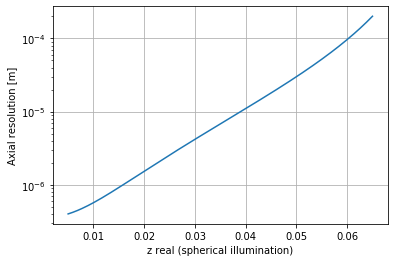

In [5]:
import matplotlib.pyplot as plt
D = M*p
L = 80e-3
zp = np.linspace(5e-3, 65e-3,200)
z = zp*L/(L-zp)
NA = np.sin(np.arctan(D/2/z))
delta_z = wavelength / NA**2
fig, ax = plt.subplots()
ax.semilogy(zp, Delta_z)
ax.set_xlabel('z real (spherical illumination)')
ax.set_ylabel('Axial resolution [m]')
ax.grid()

Maybe it is convenient to acquire images with lower $L$ when trying to detect properly with $z \approx L$.

#### Sampling z with constant step-to-resolution ratio

When sampling from $z_0$ to $z_N$ with $N+1$ points ($N$ steps) it is interesting to have always the same step-to-resolution ratio. So, $z_0 + \sum \Delta_{zi} = z_N$, and $\Delta_{zi} = K \delta_{zi}$. This is a nonlinear equation that can be solved using a nonlinear solver. See sample_z_sph.m

## Modelos de fidelidad
Los modelos de fidelidad pueden ser que consideran ruido Gaussiano o variable Poisson.

En el caso de plantear transmisión, se puede usar $I(x,y)=|A|^2 m(x,y)$, con $m(x,y)=|h_z\ast t|^2$, $t\in \mathbb{C}^n$

Si $t=|t|e^{i\phi}$, tiene sentido usar $|t|\leq1$.

## Lensfree DIH (Gabor)
Se usa un MO para generar una fuente esférica. La fuente es realmente cónica, así que hay que asegurarse que el NA del MO alcance para cubrir toda la cámara y un poco más. El radio de la zona iluminada tiene que ser mayor a 1.1 veces la diagonal de la cámara $d$. Esto va a significar distintos NA para cada posible ubicación $z$ de la cámara con respecto al eje de propagación.
$$NA = n \sin \theta,$$
siendo $\theta$ el ángulo máximo de apertura con respecto al eje de propagación: $\theta = \arctan(\frac{1.1d}{2z})$. Entonces se puede obtener un ploteo de NA necesario en función de distancia a la cámara.

Las mínimas distancias de ubicación de las cámaras [SVS Vistek, Photron, Optronis] para un NA = 0.5 son [[33.79923946 27.58810526 18.35714048]]


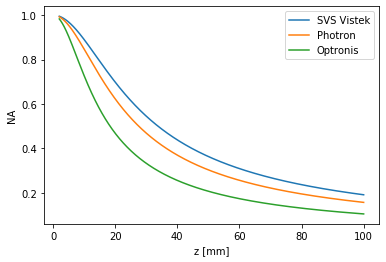

In [3]:
z = np.linspace(2,100,1000) # mm
ds = np.atleast_2d(np.array([35.48, 28.96, 19.27])) # mm. [SVS Vistek, Photron, Optronis]
NA = np.sin(np.arctan(1.1*ds/2/z[:,np.newaxis]))
fig, ax = plt.subplots(1,1)
ax.plot(z,NA)
ax.set_xlabel('z [mm]')
ax.set_ylabel('NA')
ax.legend(['SVS Vistek', 'Photron', 'Optronis'])

Test_NA = 0.5
min_zs = 1.1/2*ds / np.tan(np.arcsin(Test_NA))
print("Las mínimas distancias de ubicación de las cámaras [SVS Vistek, Photron, Optronis] para un NA = {} son {}".format(Test_NA,min_zs))

Si el NA tiene que ser 0.4 o más, de Thorlabs sólo tiene sentido el N20X-PF pra 355 nm (882£). Si no es MO, y es asférico entonces puede ser un C240TMD-A NA=0.5 con WD=4.8 mm A240TM-A en glass D-LAK6 (67£).
https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3810
Edmund Optics tiene asféricos para UV en Fused Silica. (300£) https://www.edmundoptics.com/p/125mm-dia-050-na-uv-vis-coated-uv-fused-silica-aspheric-lens/30259/ MO en 880£ 86-819

### Focusing of a laser beam to a small spot
A laser beam, with radius $y_1$ and divergence $\theta_1$ is focused by a lens of focal length $f$. The output angle is $\theta_2 = y_1/f$. The optical invariant tells us that we must have $y_2 = \theta_1 f$, because the product of radius and divergence angle must be constant.

Using diffraction limited formula: $r_{focused} = \lambda f / r_{in}$. But also seen $r_{focused} = 1.22 \lambda f / r_{in}$ 

The diameter of the pinhole should be 30% more than the diameter of the focused beam.

If an MO not infinity corrected is used, the $f$ is not given but instead magnification $M$ and tube lens length $L$ (160mm or 210mm). So $f=\frac{L}{M}$. The minimum radius is obtained for the diameter of the input.

https://www.edmundoptics.eu/knowledge-center/application-notes/lasers/beam-expanders/
The spatial filter has a magnification of the beam that is $M=\frac{f_2}{f_1}=\frac{40 \mm}{15.29 \mm}$. $M=r_{out}/r_{in}$, and $M=\theta_{in}/\theta_{out}$ for divergence angle in beam expanders.

In [4]:
wavelength = 355e-9
r_laser = 0.3e-3 /2 # FTSS355-Q4
theta_laser = 4e-3 # FTSS355-Q4
f1_filter = 4.51e-3 # 15.29e-3
f2_filter = 100e-3 # 40e-3
r_focus = theta_laser*r_laser
r_focus_dl = 1.22* wavelength * f1_filter / r_laser  # Focused beam diameter where pinhole goes
ph = 40e-6 /2
print("Pinhole has radius of {} um, but the radius of the focused beam is {} um by ray optics and {} um by diffraction limited. The pinhole should be around {} um.".format(ph*1e6,r_focus*1e6,r_focus_dl*1e6,r_focus_dl*1e6*1.3))
theta_focused = r_laser / f1_filter
r_filtered = theta_focused * f2_filter
theta_filtered = ph/f2_filter
print("The filtered output has radius {} um, and angle {} mrad".format(r_filtered*1e6, theta_filtered*1e3))
M = f2_filter / f1_filter
print("Using magnification M={} and disregarding the pinhole. The filtered output has radius {} um, and angle {} mrad".format(M,r_laser*M*1e6, theta_laser/M*1e3))
f_source = 12.5e-3
r_source = theta_filtered * f_source
print("The source has radius {} um".format(r_source*1e6))
print("Diffraction limited: The source has radius {} um".format(wavelength*f_source/r_filtered*1e6))

Pinhole has radius of 20.0 um, but the radius of the focused beam is 0.6 um by ray optics and 13.021873333333334 um by diffraction limited. The pinhole should be around 16.928435333333333 um.
The filtered output has radius 3325.9423503325943 um, and angle 0.2 mrad
Using magnification M=22.172949002217294 and disregarding the pinhole. The filtered output has radius 3325.942350332594 um, and angle 0.18040000000000003 mrad
The source has radius 2.5 um
Diffraction limited: The source has radius 1.3342083333333334 um


#### Using Aspheric lens with collimated wavefront at the input

Results obtained by the diffraction limit formula for a given NA and $f$.

In [5]:
NA = 0.5
f_asph = 12.5  # mm
r_in = np.tan(np.arcsin(NA))*f_asph
r_foc = 1.22 * wavelength * f_asph / r_in
print("The radius of the focused beam using a lens with input radius {:.2f} mm and f = {} mm, is {:.2f} um".format(r_in, f_asph, r_foc/1e-6))
pulse_energy = 80 # uJ
pulse_energy_density_focus = pulse_energy / (np.pi*r_foc**2) / 1e4 / 1e6 # J/cm2
print("The pulse energy density at the focus point is {:.2f} J/cm2".format(pulse_energy_density_focus))

The radius of the focused beam using a lens with input radius 7.22 mm and f = 12.5 mm, is 0.75 um
The pulse energy density at the focus point is 4525.25 J/cm2


## Spatial filter calculations for GEM532

Laser GEM532 specs:
- beam diameter : 0.9 mm
- divergence < 0.8 mrad
- polarization direction : horizontal
- coherence length: 1 cm
- operating temperature: 15-40

Set-up: aspheric lens with convex shape towards input, pinhole, collimating lens with convex towards output.

Diameter of focused beam: $d_f = \frac{4 \lambda f_1}{\pi D}$, where $f_1$ is the focal length of the aspheric lens and $D$ is the beam diameter of the laser.

The output diameter is $d_o = \frac{f_2}{f_1}D$.

The SLM at the output has dimensions 17.6 x 10.7 mm.

In [17]:
import numpy as np

wavel = 532e-9
f1 = 5.5e-3
beam_diam = .9e-3
M2 = 1   # Beam quality M^2 
f2 = 125e-3
diag_SLM = np.sqrt(17.6e-3**2 + 10.7e-3**2)

beam_diam_foc = 4*M2*wavel*f1/np.pi/beam_diam
print(f'Diameter of focused beam with beam quality M^2=1 is {beam_diam_foc/1e-6:.2f} um. The pinhole diameter should be {beam_diam_foc*1.3/1e-6:.2f} um.')
output_diam = f2/f1*beam_diam
print(f'The output diameter is {output_diam/1e-3:.2f} mm. The minimum output diameter (given by SLM) is {diag_SLM/1e-3:.2f} mm.')

Diameter of focused beam with beam quality M^2=1 is 4.14 um. The pinhole diameter should be 5.38 um.
The output diameter is 20.45 mm. The minimum output diameter (given by SLM) is 20.60 mm.


Required components:
- [Thorlabs ER3-P4](https://www.thorlabs.com/thorproduct.cfm?partnumber=ER3-P4) Cage Assembly Rod, 3" Long, Ø6 mm, 4 Pack £18.79 #1 *PO 5*
- [Thorlabs SM1Z](https://www.thorlabs.com/thorproduct.cfm?partnumber=SM1Z) Z-Axis Translation Mount, 30 mm Cage Compatible £149.57 #1 *PO 5*
- [Thorlabs SM1A3](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=1524&pn=SM1A3) Adapter with External SM1 Threads and Internal RMS Threads £13.46 #1 *PO 5*
- [Thorlabs E09RMS](https://www.thorlabs.com/thorproduct.cfm?partnumber=E09RMS) Extended RMS to M9 x 0.5 Adapter £25.78 #1 *PO 5*
- [Thorlabs C105TMD-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=C105TMD-A) f = 5.5 mm, NA = 0.6, Mounted Aspheric Lens, ARC: 350 - 700 nm £96.71 #1 *PO 5*
- [Thorlabs ST1XY-S/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=ST1XY-S/M) XY Translator with Micrometer Drives, Metric £291.28 #1 *PO 5*
- [Thorlabs P5W](https://www.thorlabs.com/thorproduct.cfm?partnumber=P5W) Ø1" Mounted Pinhole, 5 ± 1 µm Pinhole Diameter, Tungsten £87.63 #1 *PO 5*
- [Thorlabs LA1986-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LA1986-A)	N-BK7 Plano-Convex Lens, Ø1", f = 125 mm, AR Coating: 350 - 700 nm £24.41 #1 *PO 5*
- [Thorlabs CP6T](https://www.thorlabs.com/thorproduct.cfm?partnumber=CP6T) SM1-Threaded 30 mm Cage Plate, 6.0 mm Thick £14.78 #1 *PO 5*
- [Thorlabs C30L24](https://www.thorlabs.com/thorproduct.cfm?partnumber=C30L24) 30 mm Cage System Cover, 24" Long, Pack of 4 £21.83 #1 *PO 5*
- [Thorlabs ER6-P4](https://www.thorlabs.com/thorproduct.cfm?partnumber=ER2-P4) Cage Assembly Rod, 6" Long, Ø6 mm, 4 Pack £24.64 #1 *PO 5*
- [Thorlabs DCP1](https://www.thorlabs.com/thorproduct.cfm?partnumber=DCP1) Drop-In 30 mm Cage Mount, Flexure Lock, SM1 Threaded, 0.40" Thick, 2 Retaining Rings £16.98 #4 *PO 5*
- Set of lenses : N-BK7 Bi-Convex Lens, Ø1", ARC: 350-700nm
    - f = 50 mm [Thorlabs LB1471-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1471-A) £26.76 #1 *PO 5*
    - f = 100 mm [Thorlabs LB1676-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1676-A) £25.78 #1 *PO 5*
    - f = 175 mm [Thorlabs LB1294-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1294-A) £25 #1 *PO 5*
    - f = 250 mm [Thorlabs LB1056-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1056-A) £24.79 #1 *PO 5*
- [Thorlabs FMP1/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=FMP1/M) Fixed Ø1" Mirror Mount, M4 Tap £12.45 #1 *PO 5*
- [Thorlabs PF10-03-P01](https://www.thorlabs.com/thorproduct.cfm?partnumber=PF10-03-P01) Ø1" Protected Silver Mirror *(Available)*
- [Thorlabs BBE1-E02](https://www.thorlabs.com/thorproduct.cfm?partnumber=BBE1-E02) 1" Broadband Dielectric Elliptical Mirror, 400 - 750 nm £73.82 # 2 *(#1 for now)*  *PO 5*
- [Thorlabs KCB1EC/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=KCB1EC/M) Right-Angle Kinematic Elliptical Mirror Mount with Smooth Cage Rod Bores, 30 mm Cage System and SM1 Compatible, M4 and M6 Mounting Holes £151.37 # 2 *(#1 for now)* *PO 5*
- [Thorlabs SM1D12D](https://www.thorlabs.com/thorproduct.cfm?partnumber=SM1D12D) SM1 Ring-Actuated Iris Diaphragm (Ø0.8 - Ø12 mm) £51.76 #1 *PO 5*
- [Thorlabs CXY1](https://www.thorlabs.com/thorproduct.cfm?partnumber=CXY1) 30 mm Cage System, XY Translating Lens Mount for Ø1" Optics *(Available)*
- Plate for lens before focusing to the sample. 
- [Thorlabs LCP05/M](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3517&pn=LCP05#3517) 60 mm Cage-Compatible Mount for 50 mm Square Filters Up to 4 mm Thick, M4 Tap £70.40 or [Thorlabs CYLCP/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=CYLCP/M) 60 mm Cage Mount for Cylindrical Lenses, M4 Tap £76.91 *(Available)*

Not required yet:
- [Thorlabs CP30](https://www.thorlabs.com/thorproduct.cfm?partnumber=CP30) 30 mm to 30 mm Cage System Right-Angle Adapter £39.79
- [Thorlabs CP360R](https://www.thorlabs.com/thorproduct.cfm?partnumber=CP360R) Pivoting, Quick-Release, Ø1" Optic Mount for 30 mm Cage System £76.10
- [Thorlabs C6W](https://www.thorlabs.com/thorproduct.cfm?partnumber=C6W) 30 mm Cage Cube, Ø6 mm Through Holes £50.72 *Using a cube is not good powerwise*
- [Thorlabs B3C/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=B3C/M) Fixed Cage Cube Platform for C4W/C6W, Metric £19.81
- [Thorlabs C6WA/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=C6WA/M) C6W Platform Adapter Kit, Metric £34.29
- [Thorlabs B1C/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=B1C/M) Blank Cover Plate, Metric £14.93	
- [Thorlabs BS013](https://www.thorlabs.com/thorproduct.cfm?partnumber=BS013) 50:50 Non-Polarizing Beamsplitter Cube, 400 - 700 nm, 1" £168.81
- [Thorlabs CCM1-BS013/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=CCM1-BS013/M) Customer Inspired! 30 mm Cage Cube-Mounted Non-Polarizing Beamsplitter, 400 - 700 nm, M4 Tap £222.38

Around 45 cm from SLM to centre of sampled volume.

Available aspherics: 15.29 (LED), 4.51 (Spatial filter), 12.5 (divergent source) 10/3/2021

The heatsink of the laser puts the output beam into a [Thorlabs PAF-X-11-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=PAF-X-11-A&pn=PAF-X-11-A#11945) FiberPort, FC/APC, f=11.0 mm, 350 - 700 nm, Ø1.80 mm Waist. A fiber [Thorlabs M42L01](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=5794&pn=M42L01) Ø50 µm, 0.22 NA, Low OH, FC/PC-FC/PC Fiber Patch Cable, 1 m, goes then to a [Thorlabs PAF-X-2-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=PAF-X-2-A&pn=PAF-X-2-A#ad-image-0) FiberPort, FC/PC & FC/APC, f=2.0 mm, 350 - 700 nm, Ø0.33 mm Waist, that is mounted in a [Thorlabs CP08FP/M](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2958&pn=CP08FP/M) FiberPort Adapter for 30 mm Cage System, Enhanced Clamping. A [Thorlabs CFC-2X-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=CFC-2X-A&pn=CFC-2X-A#3154) Adj. FC/PC and FC/APC Collimator, f = 2.0 mm, ARC: 350-700 nm is available for using an adapter (not available) to place in a SM1 tube.

Damage threshold:
- Air/silica interface : 1 MW/cm<sup>2</sup>·area<sub>eff</sub> = MAX PWR

The effective area in single mode fibers is calculated as $\pi (\frac{\mbox{MFD}}{2})^2$, where MFD is the mode field diameter. In multimode fibers, the core diameter is used instead of MFD.

The multi-mode fiber will probably unpolarise the beam. One way of using unpolarised beams in an SLM is by using a PBS, mirror and 1/2-waveplate. But this needs a second BS to direct the returning beam back to the camera.

In [3]:
import numpy as np
# Maximum power allowed in fiber M42L01
max_pow = 1e6 * np.pi * (.005/2)**2
print(f'Maximum allowed power in the fiber is {max_pow:.2f} W.')
# A beam coming from the fiber M42L01 goes into the FiberPort PAF-X-2-A
# Let's assume that a 50 um 0.22 NA beam comes out from the fiber, 
wavel = 532e-9
f_FP = 2e-3
fiber_diam = 50e-6
beam_diam_FP = 4*wavel*f_FP/np.pi/fiber_diam
print(f'Diameter of output beam is {beam_diam_FP/1e-6:.2f} um. THIS IS NOT CORRECT')
# It does not make sense. Let's assume that the lens collimates a beam with width equal to the fiber diameter and coming out with the fiber NA.
NA_fiber = 0.22
theta_fiber = np.arcsin(NA_fiber)
beam_diam_FP = 2 * f_FP * np.tan(theta_fiber)
print(f'Geometrically, the diameter of the output beam of the FiberPort is {beam_diam_FP/1e-6:.2f} um.')
divergence = fiber_diam / f_FP
print(f'The divergence angle of the collimated beam is {divergence/1e-3:.2f} mrad.')
# This is the value that needs to be used for the calculation of the pinhole.

print('###')
beam_splitter_diag = 25.4e-3 * np.sqrt(2)
print(f'Calculations of required optics for dealing with a wide beam.\nBear in mind that optics are usually 1", 2", elliptical/1" beam splitter with axis/diagonal {beam_splitter_diag/1e-3:.2f} mm.')
# A 21 mm wide laser beam that reflects on a mirror at 45° needs a surface with diameter:
wide_in = 21e-3
angle = 46
tilted_width = wide_in / np.cos(angle*np.pi/180)
print(f'A {wide_in/1e-3:.2f} mm wide laser beam that reflects on a mirror at {angle:.2f}° needs a surface with diameter {tilted_width/1e-3:.2f} mm.')
tilted_width_2mirrors = wide_in / np.cos(angle*np.pi/180/2)
print(f'Using two mirrors, the required width is {tilted_width_2mirrors/1e-3:.2f} mm.')

print('###')
# Polarization of beam at the SLM must be 45°. The laser is horizontally polarized. 
# A half-wave plate at angle phi from horizontal direction obtains:
phi = -np.pi/8
aligned_comp = np.cos(phi) # Component of input that is aligned to the non-retarding axis
ret_comp = np.sin(phi)
# The output phasor is the sum of aligned_comp*exp(i phi) + ret_comp*exp(i (phi+pi/2))
phasor_out = aligned_comp*np.exp(1j*phi) + ret_comp*np.exp(1j*(phi+np.pi/2))
phase_out = np.angle(phasor_out)
print(f'If the half-wave plate is in an angle of {phi/np.pi*180:.2f}°, then the output angle with respect to the input is {phase_out/np.pi*180:.2f}°.')

Maximum allowed power in the fiber is 19.63 W.
Diameter of output beam is 27.09 um. THIS IS NOT CORRECT
Geometrically, the diameter of the output beam of the FiberPort is 902.10 um.
The divergence angle of the collimated beam is 25.00 mrad.
###
Calculations of required optics for dealing with a wide beam.
Bear in mind that optics are usually 1", 2", elliptical/1" beam splitter with axis/diagonal 35.92 mm.
A 21.00 mm wide laser beam that reflects on a mirror at 46.00° needs a surface with diameter 30.23 mm.
Using two mirrors, the required width is 22.81 mm.
###
If the half-wave plate is in an angle of -22.50°, then the output angle with respect to the input is -45.00°.


## Using windows
### About the diameter of the output window
Sapphire windows can be bought from Thorlabs or Edmund Optics. Thorlabs only has 1/2" (3 mm) and 1" (5 mm). Edmund offers also in diameters of 30, 31.75, 35, 38.1 mm. If the source is placed far away from the sensor, the angle of the beam arriving to the sensor with diameter $D$ is smaller, giving a wider beam where the window is placed. The distance from source to sensor $z$ can be as much as 8 cm. Assuming that there is a distance $z_w = 1.2 \cm$ between the window and the sensor, the minimum size of the window $D_w$ should satisfy $\frac{D}{z} = \frac{D_w}{z-z_w}$.

In [6]:
z = 8e-2  # m
D = 35.48e-3  # m
zw = 1.2e-2  # m
Dw = D/z*(z-zw)
print("The minimum size of the window to cover the entire sensor is {:.2f} mm".format(Dw*1000))
# Distance to make it work having a fixed Dw: (z-zw)D = z Dw -> z(D-Dw) = zw D -> z = zw D / (D-Dw)
Dw = 25.4e-3  # m
print("Maximum distance source/sensor when a \u2300{}mm window is {:.1f} mm from the sensor is {:.2f} mm.".format(Dw*1e3, zw*1000, 1e3*zw*D/(D-Dw)))

The minimum size of the window to cover the entire sensor is 30.16 mm
Maximum distance source/sensor when a ⌀25.4mm window is 12.0 mm from the sensor is 42.24 mm.


### Effects of the windows
The effect of a window with thickness $d_w$ to the spherical wavefront is analysed in terms of the geometrical ray with the largest angle $\theta_i$ impinging to the window. The output angle is equal to the output angle, but the equivalent distance that the wavefront should travel in free space to get the same effect as going through the window is $$d'=\frac{d_w \cos\theta_i}{n\sqrt{1-\left(\frac{\sin\theta_i}{n}\right)^2}} = \frac{d_w}{\tan\theta_i}\Phi(\theta_i,n); \Phi(\theta_i,n) = \frac{\sin\theta_i}{\sqrt{n^2-\sin^2\theta_i}}$$
The lateral distance from the input spot at the output is $w = d_w \Phi(\theta_i,n)$.

If $\sin \theta_i = \theta_i$, 
$$d'=\frac{d_w}{\sqrt{n^2-\theta_i^2}}$$

Max angle is 0.29 rad (16.47 deg).
The necessary diameter of the window is 3.29 mm.


C:\Users\j05625pe\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\j05625pe\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\j05625pe\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


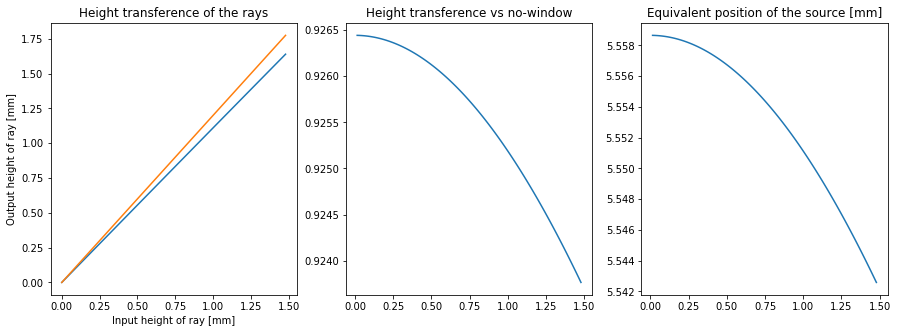

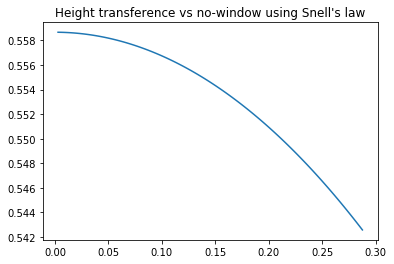

In [17]:
dw = 1e-3   # thickness window
n = 1.79   # 355 nm, 1.76 at higher wavelengths
locw = 5e-3  # Location of the window from the spherical source
L_source_sensor = 6e-2  # This distance, and the size of the sensor, are used to get the angles of interest
sensor_diagonal = 35.48e-3
max_angle = np.arctan(sensor_diagonal/2/L_source_sensor)
print("Max angle is {:.2f} rad ({:.2f} deg).".format(max_angle, max_angle*180/np.pi))
total_eq_distance = locw + dw/np.sqrt(n**2-max_angle**2)
output_rad = np.tan(max_angle)*total_eq_distance
print("The necessary diameter of the window is {:.2f} mm.".format(output_rad*2*1e3))
thetas = np.linspace(0,max_angle,100)
ys = locw * np.tan(thetas)  # height in window
# Angles of propagation inside the window
thetas_in = np.arcsin(np.sin(thetas)/n)
# Locations on the output of the window
ys_out = ys + dw*np.tan(thetas_in)
# Locations on the output if there wasn't window
ys_out_nw = (locw + dw)*np.tan(thetas)
# New source location
new_sources = np.hstack([0, ys_out[1:] / np.tan(thetas[1:])])

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(ys*1e3,ys_out*1e3,ys*1e3,ys_out_nw*1e3)
ax[0].set_title("Height transference of the rays")
ax[0].set_xlabel("Input height of ray [mm]")
ax[0].set_ylabel("Output height of ray [mm]")
ax[1].plot(ys*1e3,ys_out/ys_out_nw)
ax[1].set_title("Height transference vs no-window")
ax[2].plot(ys[1:]*1e3,1e3*new_sources[1:])
ax[2].set_title("Equivalent position of the source [mm]")

Phi = np.sin(thetas) / n /np.sqrt(1-(np.sin(thetas)/n)**2)
effects = Phi / np.tan(thetas)   
# fig,ax = plt.subplots(1,2)
# ax[0].plot(thetas,effects)
# ax[1].plot(thetas,effects*dw)
ws = dw * Phi   # displacement of beam at the output of the window
ws_free = dw * np.tan(thetas) # displacement of beam if it was free space
fig,ax = plt.subplots(1,1)
ax.plot(thetas,ws/ws_free)
ax.set_title("Height transference vs no-window using Snell's law")

# Using ABCD matrix
v_in = np.hstack((ys, thetas))
v_out = np.zeros_like(v_in)
# for 
# ABCD = 


It is important to know the diameter of the beam after the source window for the Laser Safety calculations. If the window is placed $z=1\mm$ away from the spot, and NA=0.5, the diameter is

In [ ]:
z = 1e-3
NA = 0.5
D = 2*z/np.sqrt(1/NA**2-1)
print(D)

### Using Snell's Law in Fourier space
Snell's Law:
$$n_i \sin \theta_i = n_o \sin \theta_o$$
When a particular wavefront propagating in free space goes through a flat interface with a refractive index of $n$, each spatial frequency component of the wavefront is related to an angle of incidence, $f_i(x)=a_{\theta_i} \sin(k\sin\theta_i x)$. After the interface, this component changes to $f_o(x)=a_{\theta_o} \sin(k\sin\theta_o x) = a_{\theta_o} \sin(k/n\sin\theta_i x)$. Where the change of amplitude is calculated from the Fresnel coefficients that depend on polarization.

### Using ABCD matrix
Ray tracing under the paraxial approximation is done using the ABCD matrix formulation.
\\[ \begin{bmatrix} y_2\\ \theta_2\end{bmatrix} = \begin{bmatrix} A & B\\C & D \end{bmatrix} \begin{bmatrix} y_1\\ \theta_1\end{bmatrix} \\]
Usual matrices are:
\\[\mbox{Propagation }\begin{bmatrix} 1 & 0\\d & 1 \end{bmatrix} \mbox{, Lens with focal length } f \begin{bmatrix} 1 & -\frac{1}{f}\\0 & 1 \end{bmatrix} \mbox{, Flat interface } \begin{bmatrix} 1 & 0\\0 & \frac{n_1}{n_2} \end{bmatrix} \mbox{, Single prism } \begin{bmatrix} k & \frac{d}{nk} \\ 0 & \frac{1}{k} \end{bmatrix},\\]
\\(k = (cos{\displaystyle \psi }/cos{\displaystyle \phi })\\) is the beam expansion factor, where ${\displaystyle \phi}$ is the angle of incidence, ${\displaystyle \psi }$  is the angle of refraction, $d =$ prism path length, $n =$ refractive index of the prism material. This matrix applies for orthogonal beam exit.


## Spatial filter with 3 lenses to get higher beam magnification
A third positive (biconvex) relay lens is added between typical lenses. The lens will image the focused beam to the focal point of the output lens.

If a magnification $M=\frac{d_o}{d_i}$ is seeked, and $\frac{1}{f_r}=\frac{1}{d_i}+\frac{1}{d_o}$, choosing a particular $f_r$, will get a distance from centre of the lens to the focused beam (pinhole) and the distance $d_i$ from the lens to the imaged focused beam. So,
$$d_i = \frac{M+1}{M} f_r$$
$$d_o = M d_i$$

In [ ]:
M = 1/3
f = 25
di = (M+1)/M*f
do = M*di
print("d_o = {} mm, d_i = {} mm".format(do, di))

## A neutral density filter calculation

I have an NDF with OD = 0.5 and I want another one that attenuates half of that. $T_1 = I/I_0 = 10^{-0.5}$. I want double output. $T_2 = 2 T_1 = 10^{-x}$. So, $x = 0.5 - \log_{10}2$.

In [ ]:
print(0.5-np.log10(2))

## POs

Purchase orders (PO) Counting in DH Setups notebook too. Requisitions:

5. 1986114  Creation Date 22/03/2021
